PART1:Crawling data from steam platform.In this part,I will write a Specific Crawler to gather data.The crawler code will be saved separately.

PART2:Prepare the environment and preprocess the data.

In [ ]:
#Prepare for the environment
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip3 install sentencepiece

import numpy as np 
import pandas as pd 
import re
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.compat.v1.keras.layers import CuDNNGRU
import tensorflow_hub as hub
import tokenization

import warnings as wrn
wrn.filterwarnings('ignore')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

     |████████████████████████████████| 1.2 MB 13.5 MB/s 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16654589627873321320
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6877790826344653325
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
#Get the csv file from Files and output the information of data
data = pd.read_csv("steam_reviews.csv",error_bad_lines=False)
data.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


We can see from the output that the amount of data is pretty large: about 450000 pieces of data.

In [ ]:
#output the length of data
print(len(data))

434891


We output the mean,variance and maximum of the data,and thrilled to find that the longest playing time was 32000 hours and most helpful comment is about 280000.

In [ ]:
#describe the data
data.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


As we can see from value_counts and graph,most of the reviews are positve.

In [ ]:
#Count the number of recommended comments and the number of non-recommended comments
data.recommendation.value_counts()

Recommended        303593
Not Recommended    131298
Name: recommendation, dtype: int64

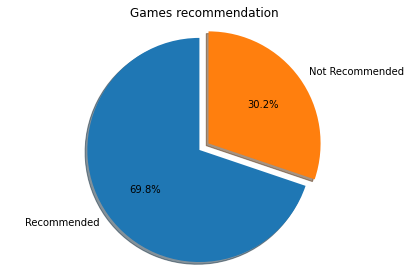

In [ ]:
#Let's see the percentage of Recommandation and non-Recommandation
sizes = [data.recommendation.value_counts()[0], data.recommendation.value_counts()[1]]
labels = ['Recommended', 'Not Recommended']
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.set_title('Games recommendation')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()

The graph looks ugly, but we can see here that a greater number of reviews are made by players who played only a few hours, and very few reviews where players played for really long.

Text(0, 0.5, 'Number of reviews')

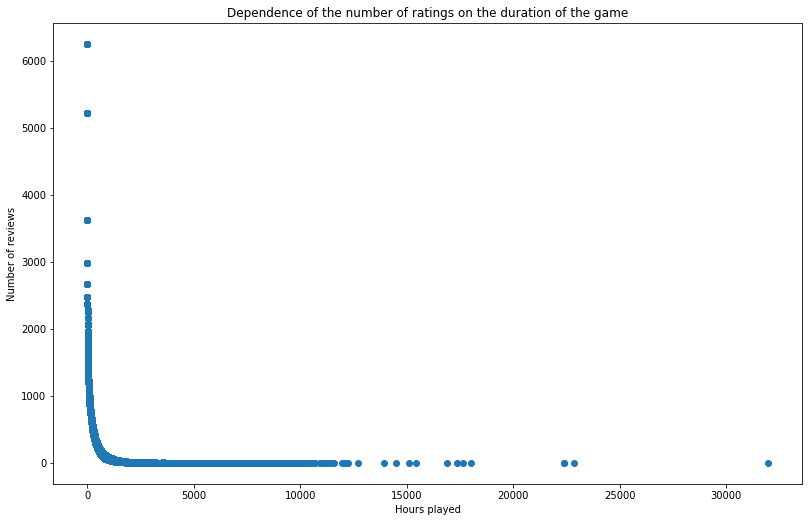

In [ ]:
#Statics hourly played trend graph
data['hour_played_reviews'] = data.groupby('hour_played')['hour_played'].transform('count')
x = data.hour_played
y = data['hour_played_reviews']
fig = plt.figure(figsize = (13,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(x,y)
ax.set_title('Dependence of the number of ratings on the duration of the game')
ax.set_xlabel('Hours played')
ax.set_ylabel('Number of reviews')

Data contain reviews from Steam's best selling games as February 2019,and as we can see from the list:PLAYERUNKNOWN'S BATTLEGROUNDS's Attention is the highest. \\



In [ ]:
#output the top reviewed game 10
top_reviewed_games = data.title.value_counts()
print('Top 10 reviewed games:\n\n{}'.format(data.title.value_counts()[:10]))

Top 10 reviewed games:

PLAYERUNKNOWN'S BATTLEGROUNDS                  145685
Grand Theft Auto V                              99956
Rust                                            71088
Rocket League®                                  67907
Dead by Daylight                                22221
MONSTER HUNTER: WORLD                           18412
ASTRONEER                                        2661
The Elder Scrolls V: Skyrim Special Edition      1473
RESIDENT EVIL 2 / BIOHAZARD RE:2                 1385
Sid Meier’s Civilization® VI                      522
Name: title, dtype: int64


In [ ]:
#Assign Recommended = 1 and non-Recommended = 0
#Inorder to train word vectors,we set Recommended as 1 and non-Recommended as 0
data = data.assign(y = (data.recommendation == 'Recommended').astype(int))
data.head(30)
data_cut1 = data

In [ ]:
#Clean the text and remove useless words
def cleanTexts(data):
    cleaned = []
    label = []
    pattern = "[^a-zA-Z0-9]"
    for da,la in zip(data.review,data.y):
        try:
           clrd = re.sub(pattern," ",da).lower().strip()
           cleaned.append(clrd)
           label.append(la)
        except:
            pass
    return cleaned,label

In [ ]:
#clean data
print("before clean: "+str(len(data_cut1)))
x_cleaned,x_label = cleanTexts(data_cut1)
print("after clean string: "+str(len(x_cleaned)))
print("after clean label: "+str(len(x_label)))

before clean: 434891
after clean string: 433375
after clean label: 433375


In [ ]:
#Dropping unrelevant features and at this time we only consider user's recommandation as the only one feature
y = x_label
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 

In [ ]:
#Tokenizing and Padding data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_cleaned)
x_tokens = tokenizer.texts_to_sequences(x_cleaned)

In [ ]:
#check the sequences
print(x_tokens[0])

print(len(x_tokens[0]))
print(len(x_tokens[1]))
print(len(x_tokens[2]))

[120, 86, 34, 120, 1751, 18, 120, 23, 20, 895, 28, 122, 260, 120, 13, 872, 4, 31, 4, 120, 31, 945, 2, 9, 3539]
25
1
30


In [ ]:
#save the maxlen token
len_arr = [len(s) for s in x_tokens]
#find the third quarter value
MAX_LEN = int(np.percentile(len_arr,75))

print(MAX_LEN)

39


In [ ]:
#padding
x_tokens_pad = pad_sequences(x_tokens,maxlen=MAX_LEN)
x_tokens_pad.shape

(433375, 39)

In [ ]:
#Split the train and test data
x_train,x_test,y_train,y_test = train_test_split(x_tokens_pad,np.asarray(y),test_size=0.2,random_state=42)

In [ ]:
#output the shape
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(346700, 39)
(86675, 39)
(346700,)
(86675,)


Part 3:Build two different models to do sentiment analysis.  \\
Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.The GRU is like a long short-term memory (LSTM) with a forget gate,but has fewer parameters than LSTM, as it lacks an output gate.GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets. \\
Because GRU model based on GPU, so we need to use GPU as Hardware accelerator. \\


In [ ]:
#Using GRUModel
#Building model: I Will use GRU (Gated Recurrent Units) to aviod vanishing gradient.
VOCAB_SIZE = len(tokenizer.word_index) + 1
# We've added 1 because of padding
# Each world will be 100D vector.
VECTOR_SIZE = 100

def GRUModel(MAX_LEN,embedding_weights=None):
    
    model = keras.Sequential()
    if embedding_weights is not None:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN,
                                   weights=[embedding_weights],
                                   trainable=True
                              ))
        
    else:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN
                                  ))
    
    model.add(CuDNNGRU(512,return_sequences=True))
    model.add(CuDNNGRU(1024,return_sequences=True))
    model.add(CuDNNGRU(1024,return_sequences=False))
    model.add(layers.Dense(1,activation="sigmoid"))
    
    model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model

Training with GloVe 100D Embeddings. \\
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. For more info: https://nlp.stanford.edu/projects/glove/.

In [ ]:
#load pre-trained data
!wget https://www.dropbox.com/s/ewfdwppopt3pild/glove.twitter.27B.100d.txt.zip?dl=1
!unzip glove.twitter.27B.100d.txt.zip?dl=1

print("Loading word embeddings...")
embedding_vector = dict() # Initialize an empty dictionary
embedding_dir = 'glove.twitter.27B.100d.txt'

f = open(embedding_dir,encoding="utf8")
for line in f:
    values = line.split() # Split the line on white space
    word = values[0] # This is the word, so use it as the key
    coefs = np.asarray(values[1:], dtype='float32') # Here are the values for each dimension of the vector for this word
    embedding_vector[word] = coefs # Add to the dictionary
f.close()

print('Loaded %s word vectors.' % len(embedding_vector))

--2021-12-13 21:41:19--  https://www.dropbox.com/s/ewfdwppopt3pild/glove.twitter.27B.100d.txt.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ewfdwppopt3pild/glove.twitter.27B.100d.txt.zip [following]
--2021-12-13 21:41:19--  https://www.dropbox.com/s/dl/ewfdwppopt3pild/glove.twitter.27B.100d.txt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf4e1c1fdd2cba1010befa020f0.dl.dropboxusercontent.com/cd/0/get/BbwVe_ePVTv_Qn0pYSnDLA1INFyqggbBFxXlLqhp3YyK1E3o2Kz1vv4PxARvIdqGNq8M2Do7wk_MhLXLd5dbB7pGAEEN_yEI_k7y4Q4WoBP1-j2o1ppCZOrBnW-wL5F5jzg3_uzzqHmtIeigMxYmcB1b/file?dl=1# [following]
--2021-12-13 21:41:20--  https://ucf4e1c1fdd2cba1010befa020f0.dl.dropboxusercontent.com/cd/0/get/BbwVe_ePVTv_Qn0pYSnDLA1INFyqggb

In [ ]:
#building embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE,100))

for i in range(1, (tokenizer.num_words-1)):

  word = tokenizer.index_word[i] # This is the string value we want to use for the lookup
  embedding_value = embedding_vector.get(word) # This does the dictionary lookup
  if embedding_value is not None: 
    embedding_matrix[i] = embedding_value 

embedding_matrix.shape

(188652, 100)

In [ ]:
#build model
GRUmodel = GRUModel(MAX_LEN,embedding_matrix)
GRUmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 100)           18865200  
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 39, 512)           943104    
                                                                 
 cu_dnngru_1 (CuDNNGRU)      (None, 39, 1024)          4724736   
                                                                 
 cu_dnngru_2 (CuDNNGRU)      (None, 1024)              6297600   
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 30,831,665
Trainable params: 30,831,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train and save model
GRUmodel.fit(x_train,y_train,epochs=10,validation_split=0.2)
GRUmodel.save("GRUModel.h5")

Epoch 1/10
8668/8668 [==============================] - 348s 40ms/step - loss: 0.3199 - accuracy: 0.8609 - val_loss: 0.2906 - val_accuracy: 0.8761
Epoch 2/10
8668/8668 [==============================] - 339s 39ms/step - loss: 0.3013 - accuracy: 0.8692 - val_loss: 0.2908 - val_accuracy: 0.8761
Epoch 3/10
8668/8668 [==============================] - 340s 39ms/step - loss: 0.2640 - accuracy: 0.8888 - val_loss: 0.2778 - val_accuracy: 0.8814
Epoch 4/10
8668/8668 [==============================] - 338s 39ms/step - loss: 0.2447 - accuracy: 0.8982 - val_loss: 0.2973 - val_accuracy: 0.8755
Epoch 5/10
8668/8668 [==============================] - 339s 39ms/step - loss: 0.2300 - accuracy: 0.9052 - val_loss: 0.2863 - val_accuracy: 0.8793
Epoch 6/10
8668/8668 [==============================] - 341s 39ms/step - loss: 0.2188 - accuracy: 0.9103 - val_loss: 0.2986 - val_accuracy: 0.8775
Epoch 7/10
8668/8668 [==============================] - 341s 39ms/step - loss: 0.2141 - accuracy: 0.9123 - val_loss: 0

We run 10 epoch, it takes about 2h to train the data,and the final Accuracy of prediction is 92%,not bad for the result. \\


Accuracy:  0.8730429766368618


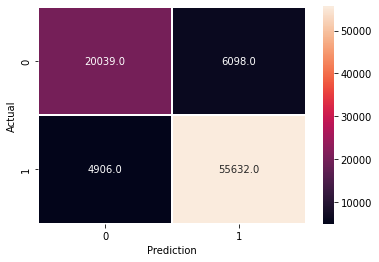

In [ ]:
#output the result
prediction = GRUmodel.predict(x_test)
preds = []
for x in prediction:
    preds.append(int(x.round()))

from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(preds, y_test))

conf_matrix = confusion_matrix(y_pred=preds,y_true=y_test)

plt.subplots()
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".1f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems). \\
Because LSTM model not based on GPU, so we need to use CPU as Hardware accelerator. \\

In [ ]:
#Using LSTM MODEL
#build LSTM MODEL
def LSTMmodel(MAX_LEN,embedding_weights=None):
    model = keras.Sequential()
    if embedding_weights is not None:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN,
                                   weights=[embedding_weights],
                                   trainable=True
                              ))
        
    else:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN
                                  ))
    model.add(layers.LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
#Build the model
lstmmodel = LSTMmodel(MAX_LEN,embedding_matrix)
lstmmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 100)           18865200  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 18,945,701
Trainable params: 18,945,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train by LSTM Model
lstmmodel.fit(x_train,y_train,epochs=10,validation_split=0.2)
lstmmodel.save("LstmModel.h5")

Epoch 1/10
8668/8668 [==============================] - 90s 10ms/step - loss: 0.3145 - accuracy: 0.8618 - val_loss: 0.2830 - val_accuracy: 0.8782
Epoch 2/10
8668/8668 [==============================] - 89s 10ms/step - loss: 0.2683 - accuracy: 0.8861 - val_loss: 0.2755 - val_accuracy: 0.8830
Epoch 3/10
8668/8668 [==============================] - 89s 10ms/step - loss: 0.2449 - accuracy: 0.8967 - val_loss: 0.2766 - val_accuracy: 0.8832
Epoch 4/10
8668/8668 [==============================] - 89s 10ms/step - loss: 0.2222 - accuracy: 0.9074 - val_loss: 0.2854 - val_accuracy: 0.8818
Epoch 5/10
8668/8668 [==============================] - 88s 10ms/step - loss: 0.1974 - accuracy: 0.9194 - val_loss: 0.3038 - val_accuracy: 0.8782
Epoch 6/10
8668/8668 [==============================] - 89s 10ms/step - loss: 0.1719 - accuracy: 0.9312 - val_loss: 0.3311 - val_accuracy: 0.8754
Epoch 7/10
8668/8668 [==============================] - 89s 10ms/step - loss: 0.1481 - accuracy: 0.9415 - val_loss: 0.3668 -

We run 10 epoch, it takes about 2.5h to train the data,and the final Accuracy of prediction is 93%,not bad for the result. compared with GRU model,Slightly inferior. \\


Accuracy:  0.8657398327083934


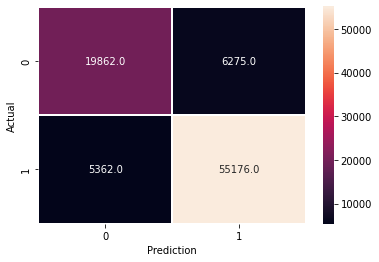

In [ ]:
#output the result
prediction = lstmmodel.predict(x_test)
preds = []
for x in prediction:
    preds.append(int(x.round()))

from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(preds, y_test))

conf_matrix = confusion_matrix(y_pred=preds,y_true=y_test)

plt.subplots()
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".1f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()